# Building a Robot Judge - Problem Set 1 - Solution Raphael Husistein

In [1]:
import os
import re
import pip
import sys
from collections import Counter
from itertools import islice
import spacy
import nltk
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer


## General functions that are used across solutions (possibly for later reuse)

In [2]:
def get_all_case_filenames():
    """Return a list of all filenames in the cases directory"""
    cases = []
    for root, dirs, files in os.walk("./cases/", topdown=False):
        for name in files:
            cases.append(os.path.join(root, name))
    return cases

def get_cleaned_string_from_file(filename):
    """Return the content of a file as a string with the first line removed and newlines striped"""
    with open(filename, "r", encoding="utf-8") as file:
        # skip the first line with the name of the judge
        content = ""
        for line in islice(file, 1, None):
            content += line.strip()
    return content

def get_spacy_doc(nlp, string):
    """Load a string into a spacy document"""
    return nlp(string)

def get_sentences(nlp, doc):
    """Return all sentences of a spacy doc"""
    return [sent.string.strip() for sent in doc.sents]

def get_words(nlp, doc):
    """Return all tokens except punctuation from a spacy document (=words)"""
    return [token.text for token in doc if not token.is_punct and not token.is_currency and not token.like_num]

def get_year_from_filename(filename):
    """Return the year extracted from the filename"""
    return re.search("\d{4}", filename).group(0)

def get_case_name_from_filename(filename):
    """Return the case name extracted from the filename"""
    return re.search("(?<=\d{4}\_).*(?=\.)", filename).group(0)

def generate_ngram(word_list, n, ending_noun=False):
    """Return a list of ngrams (all words lowercase)"""
    ngrams = []
    return [" ".join([gram.lower_ for gram in ngram]) for ngram in zip(*[word_list[i:] for i in range(n)]) if not ending_noun or ngram[2].pos_ == "NOUN"]

def normalize_text(doc):
    """
    Return cleaned list of tokens
    Removes: punctuation, numbers, spaces, stop words, and drops non alphabetic chars 
    """
    tokens = [token for token in doc if not token.is_punct | token.is_space | token.like_num | token.is_stop and token.is_alpha]
    return tokens

def get_reversed_dict(filename):
    """Return dict with the case name as the key and 0/1 for overruled"""
    with open(filename, "r", encoding="utf-8") as reversed_file:
        decisions = {}
        for line in islice(reversed_file, 1, None):
            case = line.split(",")
            decisions[case[0].strip()] = int(case[1].strip())
    return decisions

def get_sentiment_score(analyser, sentence):
    """Return the sentiment score of a sentence calculated with VADER from NLTK library"""
    return analyser.polarity_scores(sentence)

## Solution for task 1

In [3]:
NUMBER_OF_CASES = 5000
nlp = spacy.load("en")
cases_dataframe = pd.DataFrame()
filenames = get_all_case_filenames()
spacy_docs = [(filename, get_spacy_doc(nlp, get_cleaned_string_from_file(filename))) for filename in filenames[:NUMBER_OF_CASES]]
for doc in enumerate(spacy_docs):
    sentences = get_sentences(nlp, doc[1][1])
    words = get_words(nlp, doc[1][1])
    cases_dataframe = cases_dataframe.append({'#-sentences': len(sentences), '#-words': len(words), '#-letters': len(doc[1][1])}, ignore_index=True)
del words # delete reference to save ram
del filenames # free ram
cases_dataframe.hist() # histograms for task 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C07B21A58>,
      dtype=object)

## Solution for task 2

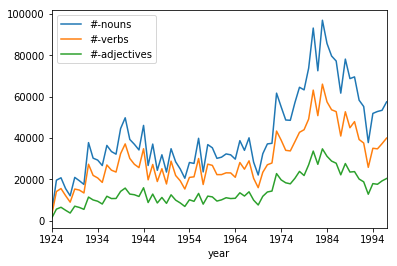

In [4]:
cases_dataframe = pd.DataFrame()
for doc in enumerate(spacy_docs):
    word_type_to_row = {"NOUN": "#-nouns", "VERB": "#-verbs", "ADJ": "#-adjectives"}
    row = {"#-nouns": 0, "#-verbs": 0, "#-adjectives": 0, "year": get_year_from_filename(doc[1][0])}
    for token in doc[1][1]:
        word_type = token.pos_
        if word_type in word_type_to_row.keys():
            row[word_type_to_row[word_type]] += 1
    cases_dataframe = cases_dataframe.append(row, ignore_index=True)
cases_dataframe = cases_dataframe.groupby(["year"])["#-nouns", "#-verbs", "#-adjectives"].sum()
cases_dataframe.plot.line()
del cases_dataframe # free some ram by setting reference counter to 0

## Solution for task 3

In [5]:
feature_set = [] # feature set of all trigramas ending with a noun
for doc in enumerate(spacy_docs):
    token_list = normalize_text(doc[1][1]) # normalize the text
    feature_set.append(
        (
            doc[1][0],
            generate_ngram(token_list, 3, ending_noun=True)
        )
    )
feature_set[0][1][0:5]

['this sugar case',
 'those concerned transactions',
 'arose referred seller',
 'referred seller buyer',
 'seller buyer bank']

## Solution for task 4

In [6]:
# get the 1000 most common trigrams
trigram_frequencies = Counter()
case_names = []
for case in feature_set:
    for trigram in case[1]:
        case_names.append(get_case_name_from_filename(case[0]))
        trigram_frequencies.update({trigram:1})
most_common = trigram_frequencies.most_common()[:1000]
features = pd.DataFrame(columns=[ngram[0] for ngram in most_common])

# create a feature set with the 1000 most common trigrams for every case
for case in feature_set:
    row = { x[0]:0 for x in most_common}
    for trigram in case[1]:
        if trigram in row.keys():
            row[trigram] += 1
    standardized_features = np.asarray(list(row.values()), dtype="float64")
    row = { most_common[x[0]][0]:x[1] for x in enumerate(standardized_features)}
    features = features.append(row, ignore_index=True)

# Standardize the features to variance 1
scaler = StandardScaler(copy=False, with_mean=False, with_std=True)
features = scaler.fit_transform(features)
# now every row in the feature set corresponds to one case file
del case_names # free memory
del feature_set # free memory
del standardized_features # free memory
del most_common
features[0:10,0:10]

array([[0.        , 0.        , 0.        , 1.19749577, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.19749577, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.19749577, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

## Solution for task 5

In [8]:
cases_reversed_dict = get_reversed_dict("case_reversed.csv")
Y = np.asarray(list(cases_reversed_dict.values())[:NUMBER_OF_CASES])
X, Y = shuffle(features, Y, random_state=314)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
log_reg = LogisticRegression(solver="liblinear", max_iter=10000) # is the standard value but specified to supress warnings
log_reg = log_reg.fit(X_train, Y_train)
predict_train = log_reg.predict(X_train)
predict_test = log_reg.predict(X_test)
accuracy_train = accuracy_score(Y_train, predict_train, normalize=True)
accuracy_test = accuracy_score(Y_test, predict_test, normalize=True)
f1_train = f1_score(Y_train, predict_train)
f1_test = f1_score(Y_test, predict_test)
del cases_reversed_dict# free memory because reference still exists
print("Accuracy on Training Set: {0}, F1-Score on Training Set: {1}".format(accuracy_train, f1_train))
print("Accuracy on Test Set: {0}, F1-Score on Test Set: {1}".format(accuracy_test, f1_test))
import pickle
f = open("log_reg.dat", "wb")
pickle.dump(log_reg, f)
f.close()

Accuracy on Training Set: 0.94375, F1-Score on Training Set: 0.9498774782802405
Accuracy on Test Set: 0.79, F1-Score on Test Set: 0.8144876325088339


## Solution for task 6

In [ ]:
regularization = ["l1", "l2"]
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=regularization)
clf = GridSearchCV(log_reg, hyperparameters, cv=10, verbose=0, scoring="f1", refit=True, iid=False)
best_model = clf.fit(X_train, Y_train)

C:\Users\test\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

In [44]:
predict_test = best_model.predict(X_test)
predict_train = best_model.predict(X_train)
accuracy_train = accuracy_score(Y_train, predict_train, normalize=True)
accuracy_test = accuracy_score(Y_test, predict_test, normalize=True)
f1_train = f1_score(Y_train, predict_train)
f1_test = f1_score(Y_test, predict_test)
roc_auc_curve = roc_auc_score(predict_test, Y_test)
print("Accuracy on Training Set: {0}, F1-Score on Training Set: {1}".format(accuracy_train, f1_train))
print("Accuracy on Test Set: {0}, F1-Score on Test Set: {1}".format(accuracy_test, f1_test))
print("Best regulization Technique: ", best_model.best_estimator_.get_params()["penalty"])
print("Best value for C:", best_model.best_estimator_.get_params()["C"])
print("ROC-AUC-Curve Value:", roc_auc_curve)

Accuracy on Training Set: 0.971, F1-Score on Training Set: 0.8960573476702509
Accuracy on Test Set: 0.77, F1-Score on Test Set: 0.31137724550898205
Best regulization Technique:  l1
Best value for C: 1.0
ROC-AUC-Curve Value: 0.5840499846928836


## Solution for task 7

In [24]:
analyser = SentimentIntensityAnalyzer()
sentences_dataframe = pd.DataFrame()
for doc in spacy_docs:
    for sent in doc[1].sents:
        row = {"sentence": None, "neg": None, "neu": None, "pos": None, "compound": None}
        cleaned_sent = " ".join([token.lower_ for token in normalize_text(sent)]) # get the normalized text of a sentence
        if len(cleaned_sent) > 25: #only use sentences with at least 25 chars used to save some ram
            score = get_sentiment_score(analyser, cleaned_sent)
            row["sentence"] = cleaned_sent
            row["neg"] = score["neg"]
            row["neu"] = score["neu"]
            row["pos"] = score["pos"]
            row["compound"] = score["compound"]
            sentences_dataframe = sentences_dataframe.append(row, ignore_index=True)
del spacy_docs # free memory

In [25]:
# output the 10 sentences with highest positive sentiment
sentences_dataframe.sort_values(by="pos", ascending=False).head(10)

compound  neg    neu    pos  \
37087     0.8807  0.0  0.141  0.859   
40612     0.9022  0.0  0.142  0.858   
55164     0.6908  0.0  0.149  0.851   
90285     0.8750  0.0  0.154  0.846   
143786    0.8519  0.0  0.163  0.837   
83852     0.6249  0.0  0.164  0.836   
109070    0.6124  0.0  0.167  0.833   
3195      0.8658  0.0  0.171  0.829   
27228     0.5574  0.0  0.179  0.821   
137341    0.8442  0.0  0.180  0.820   

                                                 sentence  
37087   even bargain fair special reasons granting relief  
40612     such agreement promotive best interests parties  
55164                      peaceable harmonious community  
90285    anyone free join committee support encouragement  
143786  good faith substantial progress indispensable ...  
83852                        certainly conclusion clearly  
109070                      foregoing special endorsement  
3195                champion spark plug champion ignition  
27228                          consent parties sufficient  
137341                     at best united states entitled

In [26]:
# output the 10 sentences with highest negative sentiment
sentences_dataframe.sort_values(by="neg", ascending=False).head(10)

compound    neg    neu  pos  \
78209    -0.8074  1.000  0.000  0.0   
115748   -0.9705  0.959  0.041  0.0   
149701   -0.9246  0.935  0.065  0.0   
13532    -0.8625  0.906  0.094  0.0   
57676    -0.8591  0.905  0.095  0.0   
112396   -0.8360  0.899  0.101  0.0   
125419   -0.7351  0.878  0.122  0.0   
63812    -0.9042  0.868  0.132  0.0   
66850    -0.9062  0.860  0.140  0.0   
73286    -0.9432  0.850  0.150  0.0   

                                                 sentence  
78209                         sentenced criminal contempt  
115748  guilty death penalty guilty charged guilty rea...  
149701  indeed fear criminal prosecution graver inhibi...  
13532                        damages claimed injury death  
57676                         i called damn liars i lying  
112396             petitioner complains prejudicial error  
125419                defendants denied charges complaint  
63812   his risk loss newspaper accidentally destroyed...  
66850   a penalty punishment injury inflicted punitive...  
73286   counts charged violations criminal code charge...

## Solution for task 8

In [27]:
sentences_dataframe.drop_duplicates(inplace=True)
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(sentences_dataframe["sentence"][:3000]) # only use 3000 sentences to save ram 
x[:100]

<100x6767 sparse matrix of type '<class 'numpy.float64'>'
	with 1503 stored elements in Compressed Sparse Row format>

In [28]:
greatest_similarity = {}
lowest_similarity = {}
sentence_similarities = cosine_similarity(x)
for similarity in enumerate(sentence_similarities):
    argsort = similarity[1].argsort()
    for i in range(len(argsort)-1, 0, -1):
        index = argsort[i]
        if index != similarity[0]: 
            greatest_similarity_index = index
            break
    for index in argsort:
        if index != similarity[0]:
            lowest_similarity_index = index
            break
    greatest_similarity[similarity[1][greatest_similarity_index]] = [similarity[0],greatest_similarity_index]
    lowest_similarity[similarity[1][lowest_similarity_index]] = [similarity[0],lowest_similarity_index]

for similar_sentence in dict(sorted(greatest_similarity.items(), reverse=True)[:10]):
    index_pair = greatest_similarity[similar_sentence]
    print("------------------------------------------Very Similar Sentences--------------------------------------------------------")
    print(sentences_dataframe.iloc[index_pair[0]]["sentence"])
    print(sentences_dataframe.iloc[index_pair[1]]["sentence"])
print("----------------------------------------------------------------------------------------------------------------------------")
print()
print()
for disimilar_sentence in dict(sorted(lowest_similarity.items())[:10]):
    index_pair = lowest_similarity[disimilar_sentence]
    print("------------------------------------------Very Disimilar Sentences--------------------------------------------------------")
    print(sentences_dataframe.iloc[index_pair[0]]["sentence"])
    print(sentences_dataframe.iloc[index_pair[1]]["sentence"])
print("----------------------------------------------------------------------------------------------------------------------------")

------------------------------------------Very Similar Sentences--------------------------------------------------------
the fact capitol motor corporation lasker
capitol motor corporation lasker
------------------------------------------Very Similar Sentences--------------------------------------------------------
as said meyer boulevard broad highway feet wide narrowest point feet wide approaches park
meyer boulevard paseo swope park broad highway feet wide narrowest point feet wide approaches park
------------------------------------------Very Similar Sentences--------------------------------------------------------
borden ice cream company borden comdensed milk
borden ice cream borden condensed milk
------------------------------------------Very Similar Sentences--------------------------------------------------------
the judgment reversed cause remanded proceedings inconsistent opinion
the judgment reversed cause remanded proceedings
------------------------------------------Very 

## Solution for task 9

In [29]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(x)
predict = kmeans.predict(x)
sentences_printed = {x: [] for x in range(20)}    
for cluster in enumerate(predict):
    if len(sentences_printed[cluster[1]]) < 5:
        sentences_printed[cluster[1]].append(sentences_dataframe["sentence"][cluster[0]])
# print out 5 sentences for each cluster
for index in range(20):
    print("-------------------------------Sentences for cluster {0}----------------------------".format(index))
    for sentence in sentences_printed[index]:
        print(sentence)
    print("------------------------------------------------------------------------------------".format(index))
    print()


-------------------------------Sentences for cluster 0----------------------------
this refinement sophistry reason carries failure appellate division particular point noticed
this patent infringement suit court motion dismiss granted district court massachusetts
this case appeal order lower court dismissing appellant bill want equity
it follows trustee bankruptcy case entitled relief asked
ed follows by constitution clause section article congress given power exercise exclusive legislation cases whatsoever district columbia
------------------------------------------------------------------------------------

-------------------------------Sentences for cluster 1----------------------------
reversed authority in west coast rubber corporation
title trustee conventional deed trust assignment benefit creditors antedate deed vendor good title trustee creditors represented property repossessed delivery deed assignment
propositions decisive case
annum interest payable contract state construc

------------------------------------------------------------------------------------

-------------------------------Sentences for cluster 19----------------------------
cars philadelphia landed weights
and act approved june stat
we concede law come definite conclusion theories cases found taking view obviously controlled taken supreme court far declared
troxell widow sued defendant alleging failed provide proper safety appliances pennsylvania statute
it brought suit recover excess profits tax ground reserve fund invested position sound greatly decrease rate income
------------------------------------------------------------------------------------



In [ ]:
kmeans.predict(x)